+-------------+-------------------+
|num_loves_ind|         prediction|
+-------------+-------------------+
|          1.0| 1.1009086022984254|
|          1.0| 1.1009086022984254|
|          2.0|    2.0910299316814|
|          3.0| 3.0811512610643748|
|          0.0|0.11078727291545082|
+-------------+-------------------+
only showing top 5 rows

MSE: 0.08698933213347279
R2: 0.9999023935480779


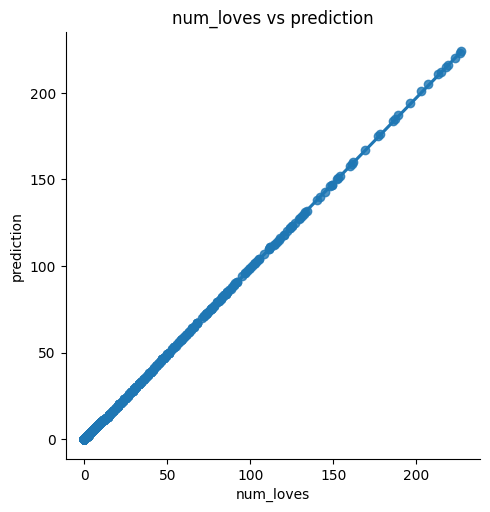

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

# Create SparkSession
spark = SparkSession.builder.appName("FBLiveTH").getOrCreate()

# Load data file into DataFrame
df = spark.read.csv("fb_live_thailand.csv", header=True, inferSchema=True)

# StringIndexer for num_reactions and num_loves
indexer_react = StringIndexer(inputCol="num_reactions", outputCol="num_reactions_ind")
indexer_loves = StringIndexer(inputCol="num_loves", outputCol="num_loves_ind")

# Fit and transform indexers
df_indexed = indexer_react.fit(df).transform(df)
df_indexed = indexer_loves.fit(df_indexed).transform(df_indexed)

# VectorAssembler for features
assembler = VectorAssembler(
    inputCols=["num_reactions_ind", "num_loves_ind"],
    outputCol="features"
)

# Linear Regression
lr = LinearRegression(
    labelCol="num_loves_ind",
    featuresCol="features",
    maxIter=10,
    regParam=0.3,
    elasticNetParam=0.8
)

# Pipeline
pipeline = Pipeline(stages=[assembler, lr])

# Split data into train and test sets
train, test = df_indexed.randomSplit([0.7, 0.3], seed=42)

# Fit pipeline model
model = pipeline.fit(train)

# Predict on test data
predictions = model.transform(test)

# Show 5 rows of predictions
predictions.select("num_loves_ind", "prediction").show(5)

# RegressionEvaluator
evaluator = RegressionEvaluator(
    labelCol="num_loves_ind",
    predictionCol="prediction"
)

mse = evaluator.setMetricName("mse").evaluate(predictions)
r2 = evaluator.setMetricName("r2").evaluate(predictions)

print(f"MSE: {mse}")
print(f"R2: {r2}")

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import col, desc

# Select num_loves and prediction columns, convert to IntegerType, order by prediction descending
selected = predictions.select(
    col("num_loves_ind").cast(IntegerType()).alias("num_loves"),
    col("prediction").cast(IntegerType()).alias("prediction")
).orderBy(desc("prediction"))

# Convert to pandas DataFrame
data = selected.toPandas()

# Plot using seaborn lmplot
sns.lmplot(x="num_loves", y="prediction", data=data)
plt.title("num_loves vs prediction")
plt.show()

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline



spark = SparkSession.builder.appName("FBLiveAnalysis").getOrCreate()

df = spark.read.csv("/content/fb_live_thailand.csv", header=True, inferSchema=True)
df.printSchema()
df.show(5)

indexer_reactions = StringIndexer(inputCol="num_reactions", outputCol="num_reactions_ind")
indexer_loves = StringIndexer(inputCol="num_loves", outputCol="num_loves_ind")

df_indexed = indexer_reactions.fit(df).transform(df)
df_indexed = indexer_loves.fit(df_indexed).transform(df_indexed)

encoder_reactions = OneHotEncoder(inputCol="num_reactions_ind", outputCol="num_reactions_vec")
encoder_loves = OneHotEncoder(inputCol="num_loves_ind", outputCol="num_loves_vec")

df_encoded = encoder_reactions.fit(df_indexed).transform(df_indexed)
df_encoded = encoder_loves.fit(df_encoded).transform(df_encoded)

df_encoded.show(5)

assembler = VectorAssembler(inputCols=["num_reactions_vec", "num_loves_vec"], outputCol="features")

pipeline = Pipeline(stages=[indexer_reactions, indexer_loves, encoder_reactions, encoder_loves, assembler])
pipeline_model = pipeline.fit(df)

df_transformed = pipeline_model.transform(df)
df_transformed.show(5)

train_data, test_data = df_transformed.randomSplit([0.8, 0.2], seed=42)

dt = DecisionTreeRegressor(labelCol="num_loves_ind", featuresCol="features")
dt_model = dt.fit(train_data)

predictions = dt_model.transform(test_data)


predictions.select("features", "num_loves_ind", "prediction").show(5)

evaluator = RegressionEvaluator(labelCol="num_loves_ind", predictionCol="prediction")

r2 = evaluator.setMetricName("r2").evaluate(predictions)
print(f"R-squared (R2): {r2}")

root
 |-- status_id: string (nullable = true)
 |-- status_type: string (nullable = true)
 |-- status_published: string (nullable = true)
 |-- num_reactions: integer (nullable = true)
 |-- num_comments: integer (nullable = true)
 |-- num_shares: integer (nullable = true)
 |-- num_likes: integer (nullable = true)
 |-- num_loves: integer (nullable = true)
 |-- num_wows: integer (nullable = true)
 |-- num_hahas: integer (nullable = true)
 |-- num_sads: integer (nullable = true)
 |-- num_angrys: integer (nullable = true)

+--------------------+-----------+----------------+-------------+------------+----------+---------+---------+--------+---------+--------+----------+
|           status_id|status_type|status_published|num_reactions|num_comments|num_shares|num_likes|num_loves|num_wows|num_hahas|num_sads|num_angrys|
+--------------------+-----------+----------------+-------------+------------+----------+---------+---------+--------+---------+--------+----------+
|246675545449582_1...|      vi